In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalizationV2
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [ ]:
data = pd.read_csv('weatherHistory.csv').drop(['Summary', 'Precip Type', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)', 'Daily Summary'], axis=1)
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'].str[:-10])
data = data.sort_values(by='Formatted Date', ascending=True)
data.set_index('Formatted Date', inplace=True)
data.head()

,Temperature (C)
Formatted Date,
2006-01-01 00:00:00,0.577778
2006-01-01 01:00:00,1.161111
2006-01-01 02:00:00,1.666667
2006-01-01 03:00:00,1.711111
2006-01-01 04:00:00,1.183333


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96453 entries, 2006-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Temperature (C)  96453 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


In [ ]:
# Train Test Split
tstart = pd.to_datetime("2016-11-01", format="%Y-%m-%d")
tend = pd.to_datetime("2016-12-15 00:00", format="%Y-%m-%d %H:%M")
def train_test_split(data, tstart, tend):
    train = data.loc[f'{tstart}':f'{tend-pd.Timedelta(minutes=1)}'].values
    test = data.loc[f'{tend}':].values
    return train, test
train, test = train_test_split(data, tstart, tend)

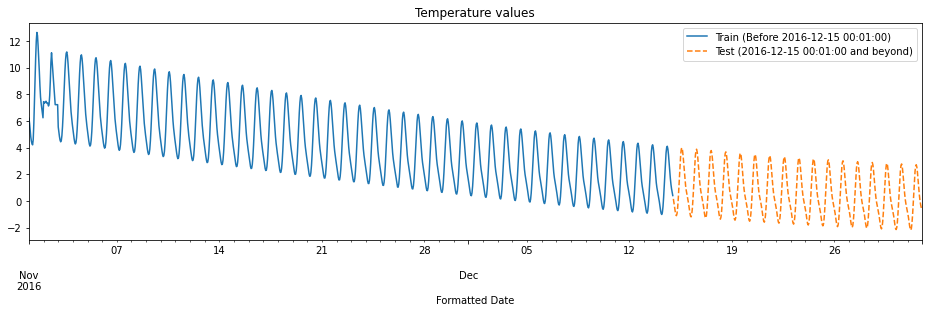

In [ ]:
# Plot of the train test split
def train_test_plot(data, tstart, tend):
    data.loc[f"{tstart}":f"{tend-pd.Timedelta(minutes=1)}", 'Temperature (C)'].plot(figsize=(16, 4), legend=True)
    data.loc[f"{tend}":, 'Temperature (C)'].plot(figsize=(16, 4), legend=True, linestyle='dashed')
    plt.legend([f"Train (Before {tend+pd.Timedelta(minutes=1)})", f"Test ({tend+pd.Timedelta(minutes=1)} and beyond)"])
    plt.title("Temperature values")
    plt.show()

train_test_plot(data,tstart,tend)

In [ ]:
# Train Data Norm
sc_train = MinMaxScaler(feature_range=(0,1))
train = train.reshape(-1, 1)
train_norm = sc_train.fit_transform(train)

# Test Data Norm
sc_test = MinMaxScaler(feature_range=(0,1))
test = test.reshape(-1, 1)
test_norm = sc_test.fit_transform(test)

In [ ]:
# X,y Split
def split_sequence(input_sequence_length, output_sequence_length, data):
    X, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        X.append(data[i-input_sequence_length:i])
        y.append(data[i:i+output_sequence_length])
    return np.array(X), np.array(y)

input_sequence_length = 144
output_sequence_length = 24
features = 1
X_train, y_train = split_sequence(input_sequence_length, output_sequence_length, train_norm)
y_train = y_train.reshape(-1, output_sequence_length)
X_test, y_test = split_sequence(input_sequence_length, output_sequence_length, test_norm)
y_test = y_test.reshape(-1, output_sequence_length)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(888, 144, 1) (888, 24)
(240, 144, 1) (240, 24)


In [ ]:
# Model Building
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=False, input_shape=(input_sequence_length, features)))
model.add(BatchNormalizationV2())
# model.add(Dropout(0.2))
model.add(Dense(output_sequence_length))

In [ ]:
# Model Compilation
model.compile(loss='mse', optimizer='Adam')

In [ ]:
# Model Callbacks
es = EarlyStopping(monitor='val_loss', patience=4, mode='min', verbose=1, restore_best_weights = True)
mc = ModelCheckpoint('model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [ ]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 150)               91200     
                                                                 
 batch_normalization_29 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_31 (Dense)            (None, 24)                3624      
                                                                 
Total params: 95,424
Trainable params: 95,124
Non-trainable params: 300
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=40, batch_size=16, callbacks=[es, mc], verbose=1)

Epoch 1/40
45/45 [==============================] - ETA: 0s - loss: 0.0840
Epoch 1: val_loss improved from inf to 0.04183, saving model to model.h5
45/45 [==============================] - 10s 178ms/step - loss: 0.0840 - val_loss: 0.0418
Epoch 2/40
45/45 [==============================] - ETA: 0s - loss: 0.0046
Epoch 2: val_loss did not improve from 0.04183
45/45 [==============================] - 8s 171ms/step - loss: 0.0046 - val_loss: 0.0473
Epoch 3/40
45/45 [==============================] - ETA: 0s - loss: 0.0038
Epoch 3: val_loss did not improve from 0.04183
45/45 [==============================] - 8s 169ms/step - loss: 0.0038 - val_loss: 0.0507
Epoch 4/40
45/45 [==============================] - ETA: 0s - loss: 0.0034
Epoch 4: val_loss did not improve from 0.04183
45/45 [==============================] - 8s 170ms/step - loss: 0.0034 - val_loss: 0.0444
Epoch 5/40
45/45 [==============================] - ETA: 0s - loss: 0.0032
Epoch 5: val_loss improved from 0.04183 to 0.03924, sa

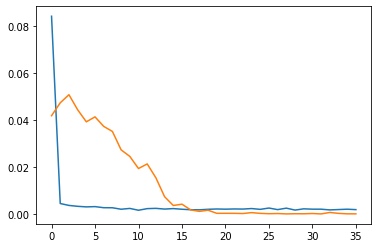

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
# Unscaling predicted data
y_pred_norm = model.predict(X_test)
y_pred = sc_test.inverse_transform(y_pred_norm)
y_test_unscaled = sc_test.inverse_transform(y_test)

8/8 [==============================] - 1s 77ms/step


In [ ]:
y_pred_norm.shape

(240, 24)

In [ ]:
# Mean Absolute Error (MAE)
MSE = mean_squared_error(y_test_unscaled, y_pred)
print(f'Mean Squared Error (MSE): {MSE:.2f}')

Mean Squared Error (MSE): 0.17


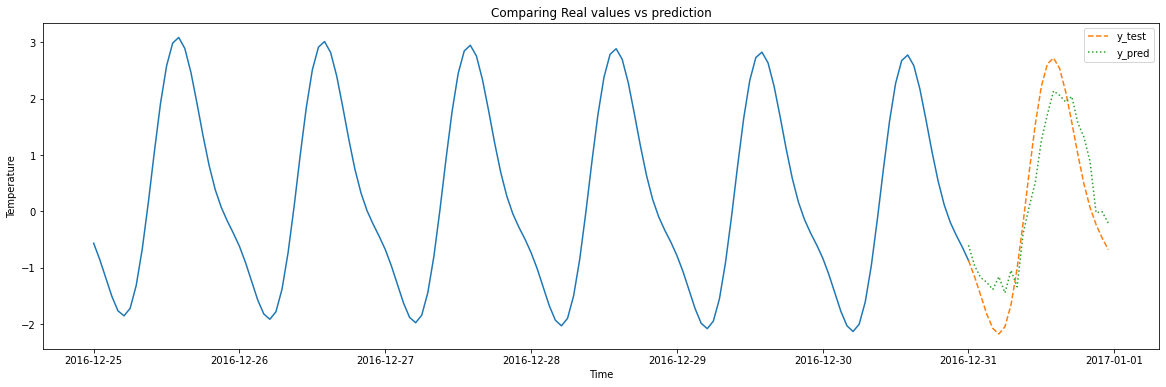

In [ ]:
# New Test of plotting
plt.figure(figsize=(20,6))
train_values = input_sequence_length + output_sequence_length
plt.plot(data.index[-train_values:-output_sequence_length+1], test[-train_values:-output_sequence_length+1])
plt.plot(data.index[-output_sequence_length:], test[-output_sequence_length:], linestyle='dashed', label='y_test')
plt.plot(data.index[-output_sequence_length:], y_pred[-1, :], linestyle='dotted', label='y_pred')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Comparing Real values vs prediction')
plt.legend()

In [ ]:
# # new data processing to match model pref for prediction
# sc_test.inverse_transform(model.predict(sc_train.fit_transform(np.array(data['MV1'])[-70:].reshape(-1, 1)).reshape(1, -1, 1)))